# Exploration of the binomial model for directionality

Based on the relative orientations of the reads of a read pair, we classify read pairs as either *simple* or *twisted*. For Hi-C and capture Hi-C data, there are roughly the same number of simple and twisted read pairs, after artifact read pairs (un-ligated, self-ligated, etc.) have been filtered out. On the other hand, there can be extreme imbalances of simple and twisted read pairs within individual interactions. We use a binomial test with $p=0.5$ to assess imbalances within individual interactions for statistical significance. For example, if an interaction has $s=5$ simple and $t=10$ twisted read pairs, then we use

$$B(k=s, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

with a certain P-value threshold to decide whether the interaction is directed or not. Conversely, if an interaction has $s=10$ simple und $t=5$ twisted read pairs, we use:

$$B(k=t, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

We have implemented the calculation of the P-value as follows:
```
def calculate_binomial_p_value(n_simple, n_twisted):
    if n_simple < n_twisted:
        p_value = 1 - binom.cdf(n_twisted - 1, n_simple + n_twisted, 0.5)
        return p_value
    else:
        p_value = 1 - binom.cdf(n_simple - 1, n_simple + n_twisted, 0.5)
        return p_value
```

This is basically a two-sided binomial test. When setting the P-value threshold, it is important to keep in mind that the test is two-sided. For example, if you want $\alpha$ to be $0.05$, then the threshold must be set to $0.025$. It is also important to be aware that we are only testing the imbalances of simple and twisted read pairs within individual interactions. The total number of read pairs ($n$) is not taken into account. Because $n$ is a parameter of the binomial distribution, we therefore actually use different null models for the evaluation of interactions with different $n$. An obvious consequence is that the power of the test decreases and increases with $n$. Another important point is that we are using a discrete distribution and therefore have discrete P-values for all combinations of $n$ and $k$.

In this Jupyter Notebook, we review our implmentation of the test for directionality of interactions and investigate how it behaves as a function of $n$. We also carry out a more theoretical analysis that is independent of our implementation of the P-value calculation. The aim of this analysis is to better understand observed periodic fluctuations in the numbers of significant interactions for different $n$. Finally, we determine the distributions of $n$ for significant and non-significant interactions from real data in order to see how our test affects the distribution of $n$ in the significant interactions.

## Setting up the notebook

Execute the cell below to set up the notebook and to create an object of the class `BinomialInteractionModel`. This class implements all function used for the following analyzes.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import scipy, scipy.stats, numpy

%matplotlib inline

# Import BinomialInteractionModel
sys.path.append("..")
from diachr import BinomialInteractionModel
bim = BinomialInteractionModel()
bim._out_prefix = "EBM"

## Verification of the implementation of the P-value calculation through simulation

In this section of the notebook, we simualte interactions and evaluate them with our implementation of the P-value calculation. For this purpose, we simulate `i_num` interactions with at most `n_max` simple and twisted read pairs by randomly selecting, for each $n$, the same number of simple read pair counts from a binomial distribution with $p=0.5$ (null model). Then we evaluate the simulated interactions using our implementation of the P-value calculation and determine the number of significant interactions at a specified P-value threshold for each $n$.

### Simulation procedure

To simulate and evaluate interactions, we need to set two parameters:

1. The maximum number of read pairs per interaction (`n_max`)
2. The number of interactions to be simulated (`i_num`)


For each $n=0, ...,$ `n_max` we draw `i=int(i_num / (n_max + 1))` simple read pair counts from the binomial distribution:

`simple_count_list = list(binom.rvs(n, p = 0.5, size = i))`

For each simple count, we determine a P-value using our implementation of the P-value calculation. If the P-value is below the half of the chosen threshold (the test is two-sided), we increment the number of significant interactions for the current $n$ by 1.

The function below implements the simualtion and returns three lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_sim_list`: List with numbers of simulated interactions for each $n$
3. `n_sig_list`: List with numbers of significant simulated interactions for each $n$

Note that all three lists are `n_max+1` in length and the index corresponds to n.

### Simulation for $n=0,...,400$ and a P-value threshold of $0.05$

Run the cell below to perform the simulation. Note that we are simulating a very large number of interactions. The reason for this is that we simulate the interactions according to our null model. Using a P-value threshold of $0.05$, we expect only 5% of the simulated interactions to be significant (actually the false positives). These 5% are distributed over $n=1,...,$ `n_max`, i.e. we expect only `p_value_cutoff*(i_num/n_max)` significant interactions for each $n$. To get a clear picture, we need as many significant interactions as possible.

In [2]:
n_max = 400
i_num = 20000000
pvt = 0.05
n_list, n_sim_list, n_sig_list = bim.simulate_interactions(n_max=n_max, i_num=i_num, pvt=pvt)

[INFO] Running simulation ...
	[INFO] Counting significant interactions for each n ...
[INFO] ...done.


Run the cell below to create a combined plot with the total numbers of simulated interactions and simulated significant interactions for each $n$.

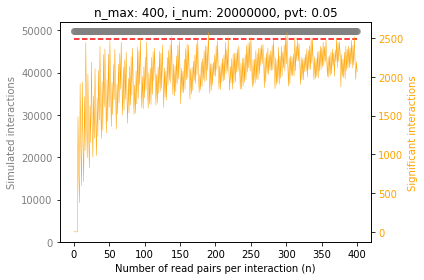

In [3]:
bim.simulate_interactions_plot(n_max=n_max, i_num=i_num, pvt=pvt,
                               n_list=n_list,n_sim_list=n_sim_list,n_sig_list=n_sig_list, CREATE_PDF=True)

The x-axis shows the number of read pairs per interaction ($n$). The left y-axis shows the total number of simulated interactions (gray). The right y-axis shows the number of significant interactions (orange). The red dahsed line relates to the right y-axis and is drawn at the level for the expected number of significant interaction for each $n$. We calculate the expected number of significant interactions by multiplying the number of all simulated interactions for any n by the chosen P-value.

It can be seen that the numbers simulated interactions (gray) are evenly distributed across the different $n$, i.e. we simulated the same number of interactions for each $n=1,...,$ `n_max`. The number of significant interactions fluctuates strongly (orange). For smaller $n<150$, the fluctuations are greater and there are often less significant interactions. After that, the curve remains just below the expected number of significant interactions (red dashed line). Finally, a periodicity can be seen, especially for larger $n$.

### Simulation for $n=0,...,400$ and a P-value threshold of $0.0019$

Now we repeat the simulation for a smaller P-value threshold. We simulate five times as many interactions as before in order to get a suffucient number of significant interactions despite the small P-value threshold. Execute the cell below (takes a few minutes).

In [4]:
n_max = 400
i_num = 100000000
pvt = 0.0019
n_list, n_sim_list, n_sig_list = bim.simulate_interactions(n_max=n_max, i_num=i_num, pvt=pvt)

[INFO] Running simulation ...
	[INFO] Counting significant interactions for each n ...
[INFO] ...done.


Run the cell below to create a combined plot with the total numbers of simulated interactions and simulated significant interactions for each $n$.

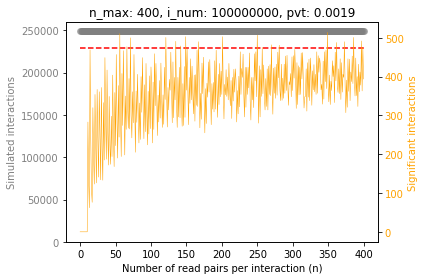

In [5]:
bim.simulate_interactions_plot(n_max=n_max, i_num=i_num, pvt=pvt,
                               n_list=n_list,n_sim_list=n_sim_list,n_sig_list=n_sig_list, CREATE_PDF=True)

Because we used a much smaller P-value threshold, we also have less significant interactions, even if we simulated 5 times as many interactions as in the first simulation. To get a comparable number of significant interactions, we actually have to simulate 25 times as many interactions, which is too time consuming. 

However, the picture is similar to the first simulation. The curve for significant interactions fluctuates strongly (orange) but remains below the expected number of significant interactions (red dashed line). Interactions with few read pairs are less often significant as interactions with many read pairs. Again, a periodicity can be seen, but not as regularly as in the first simulation. We attribute the lower regularity to the smaller number of significant interactions that result from the smaller P-value threshold.

## Binomial distributions for different n and a fixed P-value threshold

In this section of the notebook, we try to better understand the observed periodic fluctuations in the significant interactions for different $n$. For this purpose, we develop an explanatory model and check it by calculating P-values aannd associated $k$ directly from the PMF of the binomial distributions for different $n$, without using our implementation of the P-value calculation.

### Cause of periodicity and illustration procedure

Let $d_k$ be the denstity for some $k\in \{1,...,n\}$. For every $n$, the P-value threshold corresponds to a certain $k_{max}$, so that the sum $\sum_{k=0}^{k_{max}}d_k$ is as large as possible and at the same time smaller than the threshold value. If we go from $n$ to $n+1$, then the distribution becomes broader, so that the densities for all possible $k$ become smaller. A distinction must be made between two cases:

1. $\sum_{k=0}^{k_{max}+1}d_k$ *remains greater* than the P-value threshold

2. $\sum_{k=0}^{k_{max}+1}d_k$ *becomes smaller* than the P-value threshold

In the first case, we keep $k_{max}$. Since the interval remains the same and the densities become smaller overall, it becomes less likely to observe a significant $k<=k_{max}$ under the model with $n+1$. In the second case, the sum $\sum_{k=0}^{k_{max}}d_k$ becomes smaller too because the distribution becomes broader overall, but the density for $d_{k_{max}+1}$ is added to this sum. Overall, this makes it more likely to observe a significant $k<=(k_{max}+1)$ under the model with $n+1$.

For illustration purposes, we generate binomial distributions for $n=1, ..., N$. For each $n$, we determine the largest $k_{max}$ for which $\sum_{k=0}^{k_{max}}d_k$ is smaller than the half of a fixed P-value threshold. In the context of interactions, this $k$ corresponds to the largest number of simple read pairs for which the test is still significant at the given $n$. Conversely, $n-k$ corresponds to the number of twisted read pairs, which is why we are using only the half of the theshold. For each $n$, we keep track of all $k_{max}$ as well as the corresponding $\sum_{k=0}^{k_{max}}d_k$ and show them at the end in a combined plot. Optionally, each individual binomial distribution for $n=1,...,N$ can be plotted.

The function in cell below takes three arguments:

1. `N` - Binomial distributions for $n=1, ..., N$ will be generated
2. `pvt` - Fixed P-value threshold
3. `CREATE_DIST_PLOTS` - Set this to `True` to plot every single binomial distribution for $n = 1, ..., N$, otherwise only one combined plot will be generated that is explained further below.

### Binomial distributions for $n=1,...,10$ and a P-value threshold of $0.05$

First we look only at the distributions for $n=1,...,10$ so that the individual transitions from $n$ to $n+1$ can be seen better. Execute the cell below. A total of 11 Plots are generated.

Because `CREATE_DIST_PLOTS=True`, the probability mass function (PMF) binomial distribution is plotted for each individual $n$. The following is indicated above each PMF:
* Fixed P-value threshold,
* Greatest significant $k_{max}$ for the current $n$
* Associated P-value

Black vertical lines are drawn at the beginning ($0$) and at the end ($n$) of each distribution. The densities are shown as bars. As long as there is no significant $k_{max}$ at the given P-value threshold, the bars are shown in red and otherwise in blue. As soon there is a significant $k_{max}$, the edges of the distribution are highlighted accordingly (shaded light blue).

Below the PMF plots, there is another plot that summarizes the results for the individual $n$. The x-axis shows $n$. The plot has two y-axes. The left y-axis shows the calculated P-values (light blue). In addition, a trendline for the P-values is drawn (blue). To make the periodicity more visible, the P-values are shown as a line. The right y-axis shows the significant $k_{max}$ for each $n$ (black circles). In this plot, the red dashed line is simply drawn at the half of the P-value threshold.

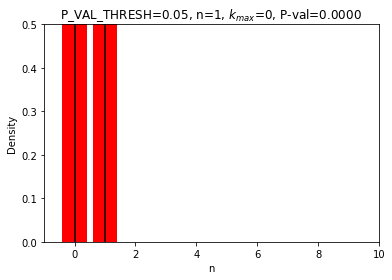

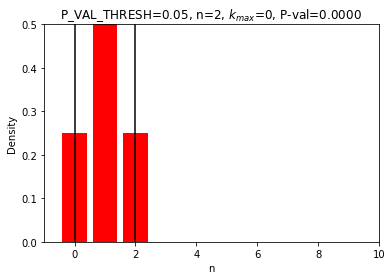

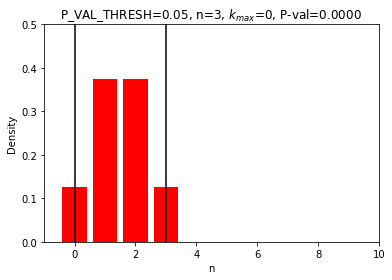

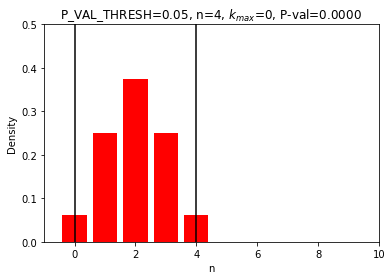

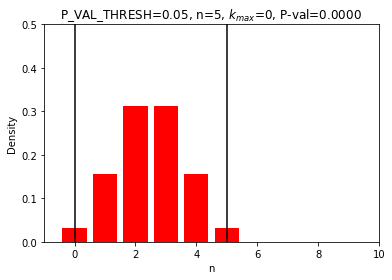

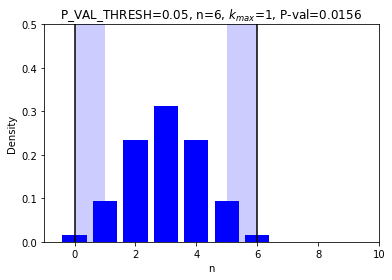

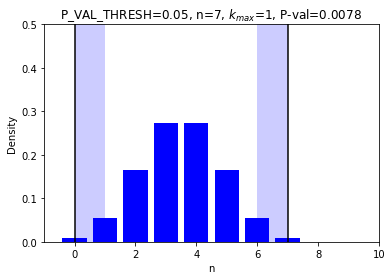

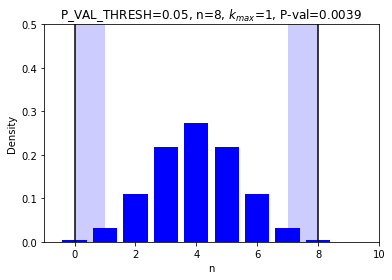

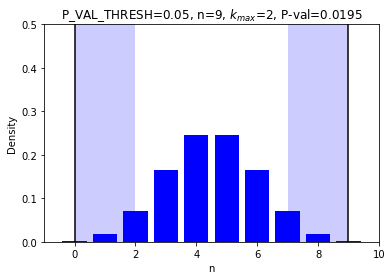

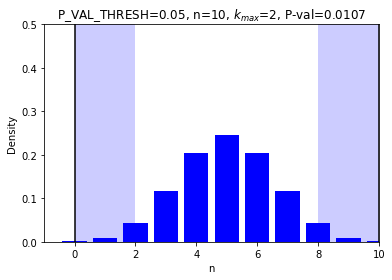

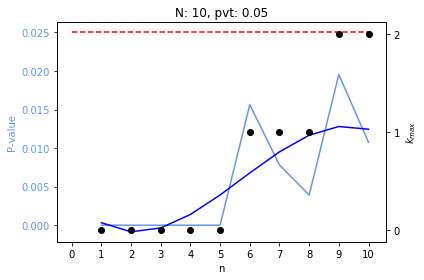

In [6]:
pvt=0.05
N=10
bim.analyze_N_binomial_distributions_with_fixed_p_thresh(N=N, pvt=pvt, CREATE_DIST_PLOTS=True, CREATE_PDF=True)

The following is a detailed description of the plots above:

* With the selected P-value threshold, there are no significant interactions for $n=1,...,5$ (the bars are shown in red). This is because even the most extreme outcomes ($k=0$) leads to a P-value that is above the threshold.

* For $n=6$, the test can be significant for the first time, where $k_{max}=1$ and the P-value is $0.0156$.

* For $n=7$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0078$. Note that it has become less likely to observe $k=1$ or $k=0$. That's because the distribution has broadened. Case one has occured.

* For $n=8$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0039$. Case one has occured.

* For $n=9$, $k_{max}$ increases  to $2$ and the P-value goes up to $0.0195$. Case two has occured.

* For $n=10$, $k_{max}=2$ remains unchanged and the P-value goes down to $0.0107$. Case one has occured.

We find that the fluctations in the numbers of significant interactions can be explained as explained at the beginning of this section. The periodicity results from the fact that we jump back and forth between two cases. In the one case, the P-value decreases because $n$ becomes larger and thus the distribution becomes wider. In the other case, the P-value increases sharply because it has become so small that $k_{max}+1$ also becomes significant. The fact that the fluctuations are greater for small $n$ could be due to the fact that, initially, fewer bins are available to compensate for an additional one. As $n$ gets larger, additional bins have less impact on the distribution and the closer the largest possible P-values can get to the threshold.

### Comparison with the results from the simualtion with $n=1,...10$ and a P-value threshold of $0.05$

For just $10$ different $n$, we can simulate much more interactions and thus have the opportunity to compare the plots from the two analyzes. Run the cell below to simualte $100,000,000$ interactions for $n=0,...,10$.

In [7]:
n_max = 10
i_num = 100000000
pvt = 0.05
n_list, n_sim_list, n_sig_list = bim.simulate_interactions(n_max=n_max, i_num=i_num, pvt=pvt)

[INFO] Running simulation ...
	[INFO] Counting significant interactions for each n ...
[INFO] ...done.


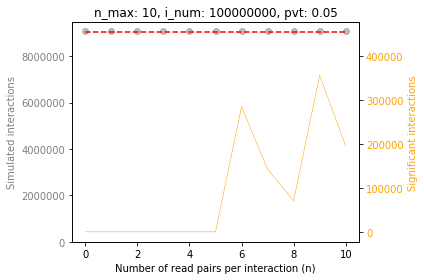

In [8]:
bim.simulate_interactions_plot(n_max=n_max, i_num=i_num, pvt=pvt,
                               n_list=n_list,n_sim_list=n_sim_list,n_sig_list=n_sig_list, CREATE_PDF=True)

The curves for the number of significant interactions (orange) and largest possible P-values (blue line in the previous plot) are almost identical. Note the slight kink at $n=7$.

### Binomial distributions for $n=1,...,40$ and a P-value threshold of $0.05$

Next we look at the distributions for $n=1,...,40$. Execute the cell below.

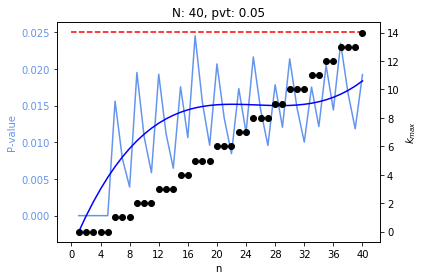

In [9]:
pvt=0.05
N=40
bim.analyze_N_binomial_distributions_with_fixed_p_thresh(N=N, pvt=pvt, CREATE_DIST_PLOTS=False, CREATE_PDF=True)

A regular pattern can be seen in which case 1 always occurs two or three times and the case 2 occurs once.

### Comparison with the results from the simualtion with $n=1,...40$ and a P-value threshold of $0.05$

We again compare our results for `n_max=40` with the results from the simulation.

In [10]:
n_max = 40
i_num = 100000000
pvt = 0.05
n_list, n_sim_list, n_sig_list = bim.simulate_interactions(n_max=n_max, i_num=i_num, pvt=pvt)

[INFO] Running simulation ...
	[INFO] Counting significant interactions for each n ...
[INFO] ...done.


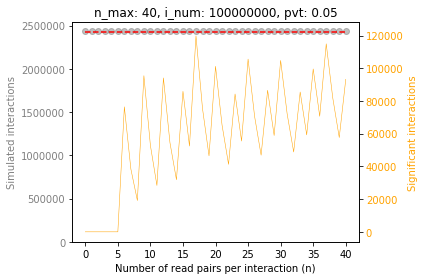

In [11]:
bim.simulate_interactions_plot(n_max=n_max, i_num=i_num, pvt=pvt,
                               n_list=n_list,n_sim_list=n_sim_list,n_sig_list=n_sig_list, CREATE_PDF=True)

The curve for the numbers of significant interactions is again comparable with the curve for the largest P-values.

### Binomial distributions for $n=1,...,400$ and a P-value threshold of $0.05$

Now we are using the same parameters that we used for the first simulation of interactions. Execute the cell below.

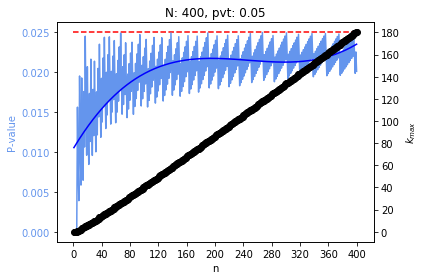

In [12]:
pvt=0.05
N=400
bim.analyze_N_binomial_distributions_with_fixed_p_thresh(N=N, pvt=pvt, CREATE_DIST_PLOTS=False, CREATE_PDF=True)

The curve shape for the P-values is reminiscent of that for simulated significant interactions. The blue fitted line for the P-values reaches a plateau at around $n=150$. After that the P-values for the various $n$ are just below the half of the chosen P-value threshold ($0.025$).

### Binomial distributions for $n=1,...,400$ and a P-value threshold of $0.0019$

Now we repeat the analysis with a smaller P-value threshold of $0.0019$. Execute the cell below.

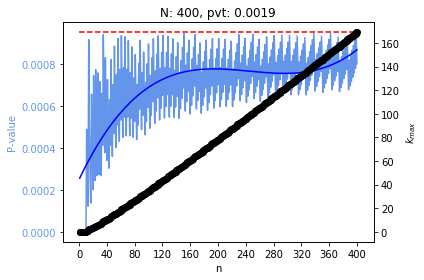

In [13]:
pvt=0.0019
N=400
bim.analyze_N_binomial_distributions_with_fixed_p_thresh(N=N, pvt=pvt, CREATE_DIST_PLOTS=False, CREATE_PDF=True)

As with the analysis with a threshold of $0.05$, a plateau is reached at around $n=150$. After that the P-values for the various $n$ are just below the half of the chosen P-value threshold ($0.00095$).

In addition to the periodic fluctuations already observed, other fluctuation with a lower frequency can be seen.

## Distribution of n for empirical data

One consequence that drew from the two studies above was that we do not simply compare directed interactions (**DI**) with all undirected interactions (**UI**), but rather with *undirected reference interactions* (**UIR**), which we select in such a way that they are comparable to directed interactions in terms of the distribution of $n$. The idea is that, in this way, both sets of interactions will be similarly affected by the irregularities we found.

In this section of the notebook, we examine the distribution of $n$ for a real dataset from a capture Hi-C experiment for megakaryocytes. For this dataset, we defined all interactions with a P-value less than $0.0019$ as directed interactions. Then we determined the distribution of $n$ for DI and selected a set of undirected reference interactions with a comparable distribution of $n$ from all undirected interactions.

For this analysis, a file in *Enhanced Interaction Format* is expected as input, with the respective interaction category in the third column. The function below implements the determination of the empirical distributions of $n$ for DI, UIR and UI and returns four lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_di_list`: List with numbers of DI for each $n$
3. `n_uir_list`: List with numbers of UIR for each $n$
4. `n_ui_list`: List with numbers of UI for each $n$

In [14]:
ie_file = '../results/06_select_reference_interactions/MK/MK_enhanced_interaction_file_with_di_ui_and_uir.tsv.gz'
if not os.path.exists(ie_file):
    raise FileNotFoundError("Could not find IE file")
n_list, n_di_list, n_uir_list, n_ui_list = bim.count_di_uir_and_ui_for_each_n(ei_file=ie_file)

	[INFO] Processed 1000000 interactions ...
	[INFO] Processed 2000000 interactions ...
	[INFO] Processed 3000000 interactions ...
	[INFO] Processed 4000000 interactions ...
	[INFO] Processed 5000000 interactions ...
	[INFO] Processed 1000000 interactions ...
	[INFO] Processed 2000000 interactions ...
	[INFO] Processed 3000000 interactions ...
	[INFO] Processed 4000000 interactions ...
	[INFO] Processed 5000000 interactions ...


The function below produces three plots:

1. The first plot shows the distribution of $n$ for UI and DI.
2. The second plot shows the distribution of $n$ for UI and UIR.
2. And the third plot shows the distribution of $n$ for DI and UIR.

In order to be able to compare the distributions of $n$ for DI, UIR and UI better, we show the relative frequencies.

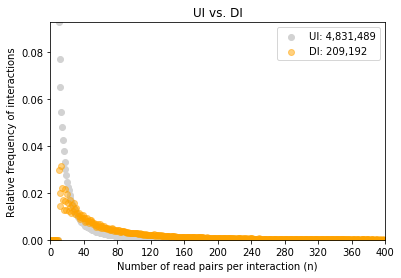

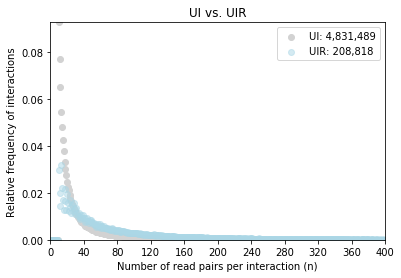

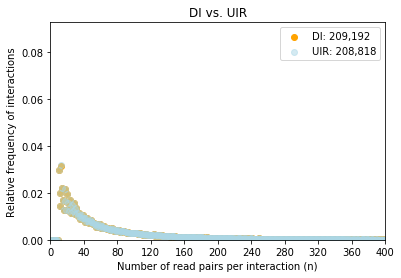

In [15]:
x_max = 400
bim.count_di_uir_and_ui_for_each_n_plot(n_list=n_list, n_di_list=n_di_list, n_uir_list=n_uir_list, n_ui_list=n_ui_list, x_max = x_max, l_wd=0.0)

The first plot shows that there's a lot more UI (gray) than DI (orange). For DI, the distribution is shifted towards larger $n$. The seconnd plot shows that the distribution for UIR (blue) is also shifted towards larger $n$ and the total number of interactions is alsmost the same as for DI (compare the numbers in the legends). The third plot shows that the distributions for DI and UIR are almost identical.

Finally, we want to investigate how the periodicity, introduced by our model, is reflected in the empirical data. For this, we take a closer look at the distributions for $n<=20$. When calling the plot function, we set an additional parameter to `l_wd=0.2`. This has the effect that neighboring points in the scatterplot are connected by lines so that the periodicity can be seen better. In aaddition, we limit the y-axis with `y_max = 0.04`.

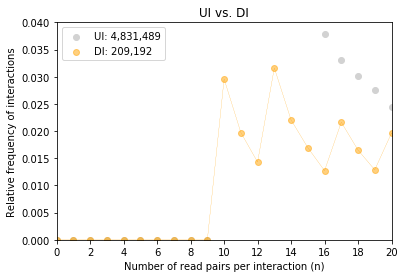

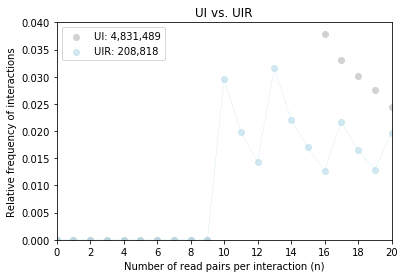

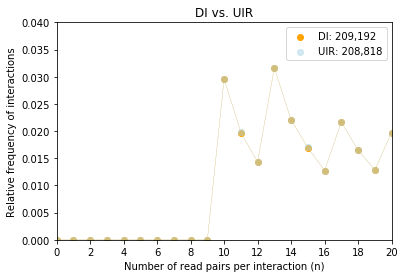

In [16]:
x_max = 20
y_max = 0.04
l_wd=0.2
bim.count_di_uir_and_ui_for_each_n_plot(n_list=n_list, n_di_list=n_di_list, n_uir_list=n_uir_list, n_ui_list=n_ui_list, x_max = x_max, y_max = y_max, l_wd=l_wd)

The distribution for DI (and UIR) shows a periodicity similar to what we saw in the previous two analyzes. At the transitions from $n$ to $n+1$, the number of DI either decreases in smaller steps or it increases sharply in one step. There are three maxima after the transitions from $n=9$ to $n=10$, $n=12$ to $n=13$ and $n=16$ to $n=17$.

Now we use our function to analyze binomial distributions and the associated maximum P-values for different $n$. We use twice the P-value threshold that was used to define DI in the empirical data because our test is two-sided. We show the maximal P-values (and associated $k_{max}$) only up to $n=20$.

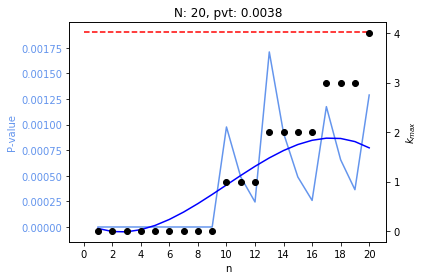

In [17]:
pvt=0.0019*2 # Our test is two-sided
N=20
bim.analyze_N_binomial_distributions_with_fixed_p_thresh(N=N, pvt=pvt, CREATE_DIST_PLOTS=False, CREATE_PDF=True)

The maxima occur at the same transitions as in the empirical data. The agreement of the periodicity continues for $n<20$ until at least $n=40$. Run the two cells above again with `x_max = 40` and `N = 40` to confirm this claim. For $40<n$ the fluctuations in the empirical data become very small so that any periodicity is difficult to identify.

## Conclusion

In this notebook, we have examined our model for the statistical evaluation directionality of interactions.

To do this, we first simulated interactions according to the null model and used our function for calculating the P-value to classify interactions as either directed or undirected. We noticed that the number of significant interactions fluctuates strongly and periodically for different $n$. In particular, we observed that interactions with smaller $n$ are classified less often as directed, although we have simulated the same number of interactions for each $n$ according to the null model. With a second analysis, which is based only on the PMF of the binomial distribution and in which our function for calculating the P-value is not used, we were able to reproduce the fluctuations in detail and for various parameter settings. Finally, we examined how our assessment of directionality affects the distribution of $n$ in real data.

The main findings from this analyzes are as follows:

* Our test for directionality of interactions is two-sided (one side is simple and the other side is twisted).

* With our model, interactions with small $n$ are preferntially classified as undirected.

* The strong periodic fluctuations result from the fact that we use *discrete* binomial distributions with different $n$ for our test.

* Our function for calculating the P-values works as indented, but the following needs to be considered:
    - For interactions with less simple than twisted read pairs, it returns the probability of observing as few or even fewer simple read pairs.
    - Conversely, for interactions with less twisted than simple read pairs, it returns the probability of observing as few or even fewer twisted read pairs.
    - Therefore, if we want an $\alpha=0.05$, we need to apply a threshold of $\alpha/2=0.025$ to the P-value.
* The periodicity is reflected in the distrubtution of $n$ for directed interactions (DI) from empirical data.
* In the case of directed interactions from real data (DI), the distribution of $n$ is shifted towards larger values.

* Undirected reference interaactions (UIR), have almost the same distribution of $n$ as compared to directed interactions (DI).